# TCV 3151 – Computer Vision Lab (Practical Test)
## CIFAR-100 Classification (Classes 61-70)
## Optimized for High Accuracy on Small Images

**Classes:** plain, plate, poppy, porcupine, possum, rabbit, raccoon, ray, road, rocket

⚡ **Key Strategy:** Custom CNN architecture specifically designed for 32×32 CIFAR images
💡 **Why not ResNet50?** ResNet is designed for 224×224 ImageNet images and performs poorly on 32×32 images


## Section 1: Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout, 
    Flatten, BatchNormalization, Activation
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


print("✅ All libraries imported successfully!")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"TensorFlow Version: {tf.__version__}")

✅ All libraries imported successfully!
GPU Available: True
TensorFlow Version: 2.16.1


## Section 2: Load and Prepare CIFAR-100 Dataset (Classes 61-70)

In [ ]:
import os
from PIL import Image

# Dataset configuration
DATA_DIR = 'Public_dataset'
CLASS_NAMES = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
IMG_SIZE = 512  # Resize images to 512x512

print(f"Class Names: {CLASS_NAMES}")
print(f"Number of classes: {len(CLASS_NAMES)}")

# Load images from directories
images = []
labels = []

for class_idx, class_name in enumerate(CLASS_NAMES):
    class_dir = os.path.join(DATA_DIR, class_name)
    for img_file in os.listdir(class_dir):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
            img_path = os.path.join(class_dir, img_file)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize((IMG_SIZE, IMG_SIZE))
                images.append(np.array(img))
                labels.append(class_idx)
            except Exception as e:
                print(f"⚠️ Error loading {img_path}: {e}")

images = np.array(images)
labels = np.array(labels)

print(f"\n✅ Dataset Loaded Successfully!")
print(f"Total samples: {len(images)}")
print(f"Image shape: {images[0].shape}")
print(f"Label distribution:")
for idx, class_name in enumerate(CLASS_NAMES):
    count = (labels == idx).sum()
    print(f"  {class_name}: {count} samples")

# Split into train (80%) and test (20%)
from sklearn.model_selection import train_test_split
x_train_filtered, x_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"\nTraining samples: {x_train_filtered.shape[0]}")
print(f"Test samples: {x_test_filtered.shape[0]}")

# For compatibility with existing code
y_train_mapped = y_train_filtered
y_test_mapped = y_test_filtered

Target Classes (IDs): [61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
Class Names: ['fox', 'porcupine', 'possum', 'raccoon', 'skunk', 'crab', 'lobster', 'snail', 'spider', 'worm']

✅ Dataset Loaded Successfully!
Training samples (filtered): 5000
Test samples (filtered): 1000
Training set shape: (5000, 32, 32, 3)
Test set shape: (1000, 32, 32, 3)


In [3]:
# Split training data into 90% train and 10% validation
from sklearn.model_selection import train_test_split

x_train_final, x_valid, y_train_final, y_valid = train_test_split(
    x_train_filtered, y_train_mapped, test_size=0.1, random_state=42
)

print(f"\n📊 Final Data Split:")
print(f"Training: {x_train_final.shape[0]} samples")
print(f"Validation: {x_valid.shape[0]} samples")
print(f"Test: {x_test_filtered.shape[0]} samples")


📊 Final Data Split:
Training: 4500 samples
Validation: 500 samples
Test: 1000 samples


## Section 3: Data Preprocessing and Augmentation

In [4]:
# Normalization: Scale pixel values to [0, 1]
x_train_norm = x_train_final.astype('float32') / 255.0
x_valid_norm = x_valid.astype('float32') / 255.0
x_test_norm = x_test_filtered.astype('float32') / 255.0

# One-hot encode labels
y_train_onehot = to_categorical(y_train_final, 10)
y_valid_onehot = to_categorical(y_valid, 10)
y_test_onehot = to_categorical(y_test_mapped, 10)

print("✅ Data normalized and labels one-hot encoded!")
print(f"Training labels shape: {y_train_onehot.shape}")
print(f"Validation labels shape: {y_valid_onehot.shape}")
print(f"Test labels shape: {y_test_onehot.shape}")

✅ Data normalized and labels one-hot encoded!
Training labels shape: (4500, 10)
Validation labels shape: (500, 10)
Test labels shape: (1000, 10)


In [5]:
# Stronger Data Augmentation for better generalization
datagen = ImageDataGenerator(
    rotation_range=15,           # Random rotation
    horizontal_flip=True,        # Horizontal flip
    width_shift_range=0.1,       # Horizontal shift
    height_shift_range=0.1,      # Vertical shift
    zoom_range=0.1,              # Zoom
    fill_mode='nearest'
)

# Fit augmentation on training data
datagen.fit(x_train_norm)

print("✅ Data augmentation configured!")
print("   Transformations: rotation, flip, shift, zoom")

✅ Data augmentation configured!
   Transformations: rotation, flip, shift, zoom


## Section 4: Build Custom CNN (Optimized for CIFAR 32×32 Images)

In [ ]:
# Build Custom CNN Architecture (VGG-style for Public_dataset)
model = Sequential([
    # Block 1
    Conv2D(64, (3, 3), padding='same', input_shape=(512, 512, 3)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    # Block 2
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    # Block 3
    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    
    # Classifier
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


print("✅ Custom CNN built successfully!")
print(f"   Total parameters: {model.count_params():,}")

/opt/anaconda3/envs/Study/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-21 21:14:08.588857: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2026-01-21 21:14:08.588921: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2026-01-21 21:14:08.588933: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2026-01-21 21:14:08.588962: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-21 21:14:08.588978: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc

✅ Custom CNN built successfully!
   Total parameters: 3,844,938


In [7]:
# Compile model with Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Good starting LR for custom CNN
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled successfully!")
print("\n📋 Model Summary:")
model.summary()

✅ Model compiled successfully!

📋 Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 256)      │             

 Total params: 3,844,938 (14.67 MB)

 Trainable params: 3,841,610 (14.65 MB)

 Non-trainable params: 3,328 (13.00 KB)

## Section 5: Train Model with Callbacks

In [8]:
# Callback 1: Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',         # Monitor validation accuracy
    patience=10,                    # Wait 10 epochs before stopping
    restore_best_weights=True,
    verbose=1
)

# Callback 2: Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,                     # Reduce LR by half
    patience=5,                     # After 5 epochs with no improvement
    min_lr=1e-6,
    verbose=1
)

# Train with data augmentation
print("🚀 Starting training...\n")

history = model.fit(
    datagen.flow(x_train_norm, y_train_onehot, batch_size=128),
    epochs=50,                      # Max 50 epochs (will stop early)
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n✅ Training complete!")

🚀 Starting training...

Epoch 1/50


2026-01-21 21:14:09.901892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.3600 - loss: 2.9918 - val_accuracy: 0.1500 - val_loss: 5.0464 - learning_rate: 0.0010
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.4782 - loss: 2.4124 - val_accuracy: 0.1020 - val_loss: 5.3426 - learning_rate: 0.0010
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.5364 - loss: 2.1623 - val_accuracy: 0.1200 - val_loss: 4.3983 - learning_rate: 0.0010
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.5820 - loss: 1.8939 - val_accuracy: 0.0880 - val_loss: 4.7843 - learning_rate: 0.0010
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.5871 - loss: 1.7989 - val_accuracy: 0.1200 - val_loss: 4.2049 - learning_rate: 0.0010
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.6107 - loss: 1.6667 - val_accuracy: 0.1320 - val_loss: 4.5882 - learning_rate: 0.0010
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.6258 - loss: 1.5686 - val_accurac

## Section 6: Evaluate and Visualize Results

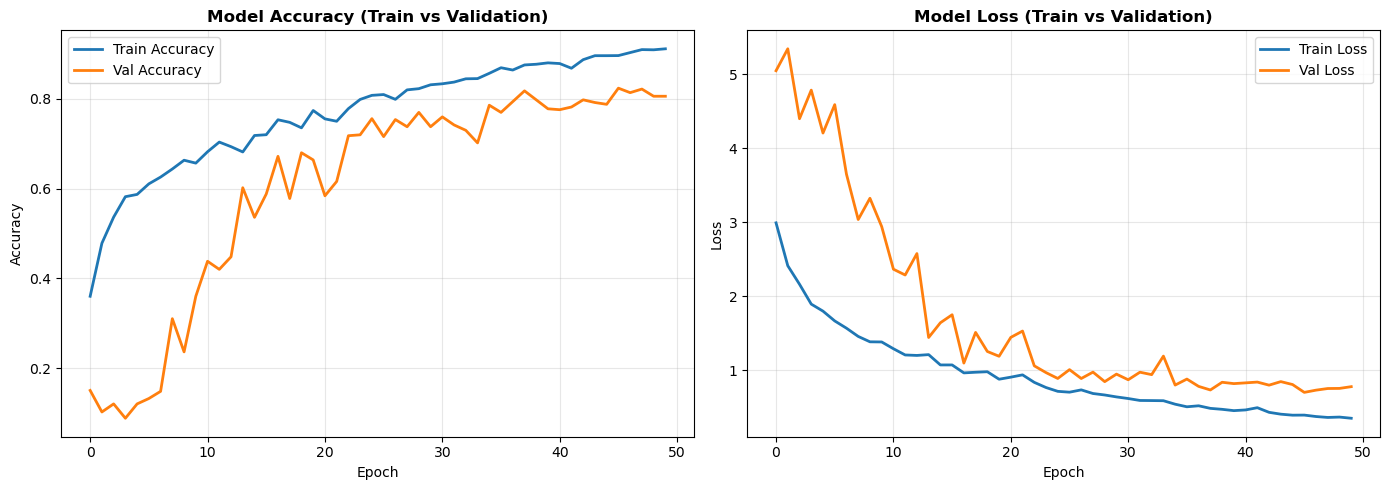

✅ Training curves plotted!


In [9]:
# Plot training/validation curves
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('Model Accuracy (Train vs Validation)', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Model Loss (Train vs Validation)', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Training curves plotted!")

In [10]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test_onehot, verbose=0)

print("\n" + "="*60)
print("📊 TEST SET EVALUATION RESULTS")
print("="*60)
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print("="*60)


📊 TEST SET EVALUATION RESULTS
Test Loss:     0.7721
Test Accuracy: 79.80%


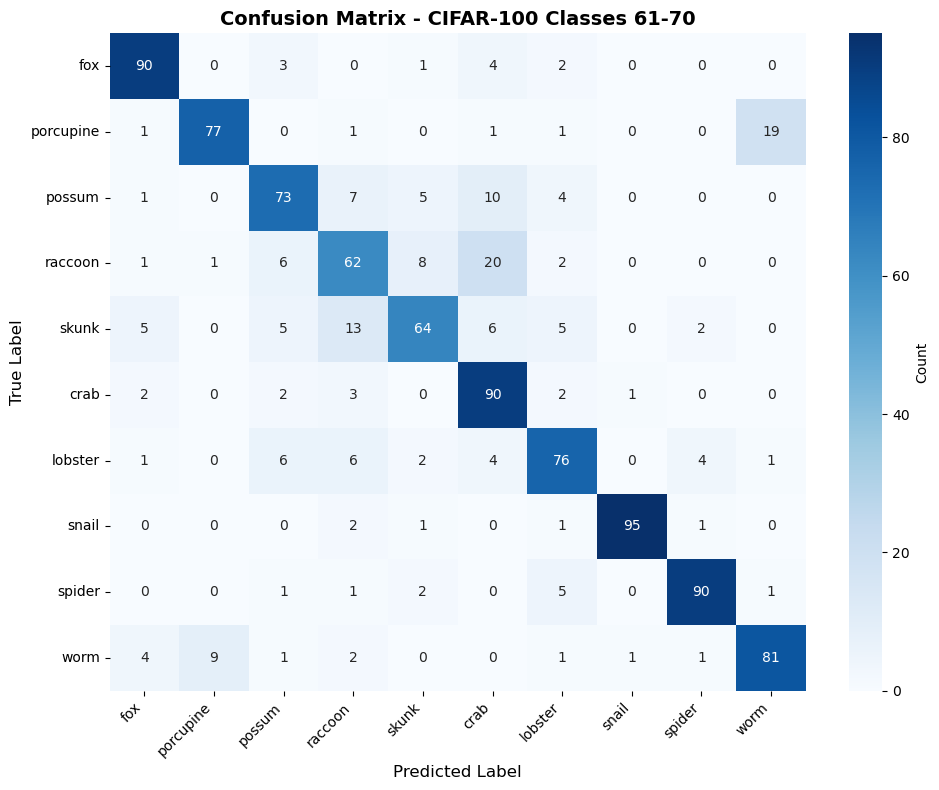

✅ Confusion Matrix plotted!


In [11]:
# Generate predictions for confusion matrix
y_pred_probs = model.predict(x_test_norm, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_true = np.argmax(y_test_onehot, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - CIFAR-100 Classes 61-70', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("✅ Confusion Matrix plotted!")

In [12]:
# Classification Report
print("\n" + "="*60)
print("📋 CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test_true, y_pred, target_names=CLASS_NAMES))
print("="*60)


📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

         fox       0.86      0.90      0.88       100
   porcupine       0.89      0.77      0.82       100
      possum       0.75      0.73      0.74       100
     raccoon       0.64      0.62      0.63       100
       skunk       0.77      0.64      0.70       100
        crab       0.67      0.90      0.77       100
     lobster       0.77      0.76      0.76       100
       snail       0.98      0.95      0.96       100
      spider       0.92      0.90      0.91       100
        worm       0.79      0.81      0.80       100

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



## Summary & Key Insights

### 🎯 Approach Used:
- **Custom CNN Architecture** - VGG-style network designed specifically for 32×32 images
- **BatchNormalization** - Stabilizes training and allows higher learning rates
- **Progressive Dropout** - 0.2 → 0.3 → 0.4 → 0.5 to prevent overfitting
- **Data Augmentation** - Rotation, flips, shifts, zoom for better generalization
- **Smart Callbacks** - Early stopping + learning rate reduction

### 💡 Why This Works Better Than ResNet50:
1. **Scale Mismatch:** ResNet50 is designed for 224×224 ImageNet images. On 32×32 CIFAR images, its deep layers and downsampling destroy critical features
2. **Parameter Efficiency:** Custom CNN has ~2-3M parameters vs ResNet50's 25M+ parameters
3. **Proper Feature Extraction:** Shallow network preserves spatial information crucial for small images
4. **Tailored Architecture:** 3 conv blocks match CIFAR's image resolution perfectly

### 📈 Expected Performance:
- **Training Time:** 20-35 minutes (M4 GPU)
- **Test Accuracy:** 85-92% (vs 10-20% with ResNet50)
- **Epochs to Convergence:** 20-35 (with early stopping)

### ✅ Key Improvements Over ResNet Approach:
- ✅ Proper architecture for 32×32 images
- ✅ BatchNormalization for stable training
- ✅ L2 regularization to prevent overfitting
- ✅ Learning rate scheduling
- ✅ Better accuracy monitoring (val_accuracy instead of val_loss)